<div style="margin: 0 auto 30px; height: 60px; border: 2px solid gray; border-radius: 6px;">
  <div style="float: left;"><img src="https://github.com/LCAV/COM202/blob/main/02-DFT/img/epfl.png?raw=1" /></div>
  <div style="float: right; margin: 20px 30px 0; font-size: 10pt; font-weight: bold;"><a href="https://moodle.epfl.ch/course/view.php?id=18253">COM202 - Signal Processing</a></div>
</div>
<div style="clear: both; font-size: 30pt; font-weight: bold; color: #483D8B;">
    Lab 2.B: the DFT: implementation, frequency plots, applications
</div>

In this two-part notebook we will study the properties and the applications of the Discrete Fourier Transform (DFT), arguably the most important analysis tool in digital signal processing.

In this second part we will focus on more practical aspects of the DFT:
 * we will look at the DFT as a numerical algorithm that we can implement
 * we will study how to plot the DFT coefficients
 * we will look at the achievable frequency resolution and frequency identification

At the end of this lab you should be able to
- understand how to plot and interpret the spectrum of a signal
- understand how to apply the DFT to real-world signals

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as wg

plt.rcParams["figure.figsize"] = (12,3)

In [2]:
# These are helper functions for the interactive plots used later in the notebook. No need to study or understand
#  the code unless you are interested in advanced plotting and interactive widgets

UC_LIM = 1.4
UC_ARW = 0.1
UC_ARC = 0.8
UC_TXT = 1.2
UC_PSZ = 5

def wcolor(w):
    if np.isclose(w, 0) or np.isclose(w, np.pi):
        return 'C0'
    elif w > 0:
        return 'C2'
    else:
        return 'C3'

def arc(a=0, b=2*np.pi, r=1, pts=60, col='C0', arrow=False):
    theta = np.linspace(a, b, pts)
    plt.plot(r * np.cos(theta), r * np.sin(theta), color=col, linewidth=2)
    if arrow:
        d = np.sign(b) * UC_ARW
        x = r * np.array([np.cos(b-d), np.sin(b-d)])
        y = r * np.array([np.cos(b), np.sin(b)]) - x
        plt.arrow(*x, *y, shape='full', lw=1, length_includes_head=True, head_width=.08, color=col)

def ucsetup():
    plt.gcf().set_figheight(UC_PSZ)
    plt.gca().set_aspect('equal', 'box')
    plt.gca().set(xlim=(-UC_LIM, UC_LIM), ylim=(-UC_LIM, UC_LIM))
    plt.axvline(0, linewidth=0.8, color='k')
    plt.axhline(0, linewidth=0.8, color='k')
    plt.axis('off')
    arc()

def ucpoint(w, lb='', col='C2'):
    x, y = np.cos(w), np.sin(w)
    plt.plot([0, x], [0, y], color=col)
    plt.plot(x, y, 'o', color=col)
    plt.text(UC_TXT * x, UC_TXT * y, lb, ha='center', va='bottom' if np.round(y)==0 else 'center')

def ctspin(w):
    w = np.fmod(w, 2 * np.pi)
    ucsetup()
    ucpoint(w, f'$e^{{j\\theta}}$', wcolor(w))
    arc(0, w, r=UC_ARC, col='C1', arrow=True)
    return w

def dtspin(N, k, n=None):
    ucsetup()
    w = 2 * np.pi / N * k
    for m in range(n+1 if n is not None else N):
        ucpoint(w * m, f'$w_{{{k}}}[{m}]$', wcolor(np.pi - w))
    ab = [0, w] if n is None else [w * (n-1), w * n]
    arc(*ab, r=UC_ARC, col='C1', arrow=True)

def ccspin(N, k, n=1):
    ucsetup()
    w = 2 * np.pi / N * k * n
    ucpoint(w, f'$w_{{{k}}}[{n}]$')
    ucpoint(-w, f'$w_{{{N-k}}}[{n}]$', 'C3')
    plt.plot([np.cos(w), np.cos(w)], [np.sin(w), -np.sin(w)], 'C6')
    plt.plot([np.cos(w), np.cos(w)], [np.sin(w), -np.sin(w)], 'oC6')
    plt.plot([0, np.cos(w)], [0, 0], 'C9')
    plt.plot(np.cos(w), 0, 'oC9')

def show_cex(N:int, k:int):
    w = 2 * np.pi / N * k
    cex = np.round(np.exp(1j * w * np.arange(N)), 3)
    plt.subplot(1,2,1)
    ucsetup()
    arc(0, w, r=UC_ARC, col='C1', arrow=True)
    pts = {np.round(np.fmod(w * n, 2 * np.pi), 2): n for n in range(N-1,-1,-1)}
    for p, n in pts.items():
        ucpoint(n * w, f'$w_{{{k}}}[{n}]$', 'C2' if n < 2 else 'lightgray')
    plt.subplot(2,2,2)
    plt.stem(cex.real)
    plt.title(f'$\\mathrm{{Re}}\\{{\\mathbf{{w}}_{{{k}}}\\}} = \\mathbf{{c}}_{{{k}}}$')
    plt.subplot(2,2,4)
    plt.stem(cex.imag)
    plt.title(f'$\\mathrm{{Im}}\\{{\\mathbf{{w}}_{{{k}}}\\}} = \\mathbf{{s}}_{{{k}}}$')
    plt.tight_layout()

def show_freqs(N:int):
    ucsetup()
    for k in range(N):
        w = 2 * np.pi / N * k
        if k < N / 2:
            ucpoint(w, f'$\\omega_{{{k}}}$', wcolor(w))
        elif k == N / 2:
            ucpoint(np.pi, f'$\\omega_{{{k}}} = \\pi$', wcolor(0))
        else:
            ucpoint(w, f'$\\omega_{{{k}}} = -\\omega_{{{N-k}}}$', wcolor(np.pi - w))
    plt.title(f'$N = {N}$')

def display_sbs(interactive_widget):
    c = interactive_widget.children
    controls = wg.HBox(c[:-1], layout=wg.Layout(align_items='center'))
    return display(wg.HBox([controls, c[-1]]))

# Introduction

The first part of this lab addressed the fundamental idea of Fourier analysis: signals can be decomposed into elementary sinusoidal components with no loss of information and this transformation of a signal from the time domain to the frequency domain is efficiently described by means of a family of harmonic complex exponentials.

In this second part we will move to more practical aspects of Fourier analysis for finite-length signals. We begin by defining here as well a few test signals used in later examples.

## Test signals

In part 1 of this two-part notebook we introduced two test signals, the square wave and the triangular wave, whose generating functions are as follows:

In [3]:
def sqw(N: int, n: np.ndarray=None) -> np.ndarray:
    n = np.arange(N) if n is None else n
    return np.sign(np.mod(n, N/2)) * np.sign(N/2 - np.mod(n, N))

def tri(N: int, n: np.ndarray=None) -> np.ndarray:
    n = np.arange(N) if n is None else n
    return (4 / N) * np.abs(np.mod(n, N) - N / 2) - 1

In this part we will also use a third test signal, a linear ramp going from -1 to +1 over $N$ samples; note that $N$ is no longer assumed to be even. The ramp can be made $N$-periodic, in which case the resulting signal is often called a "sawtooth" wave.

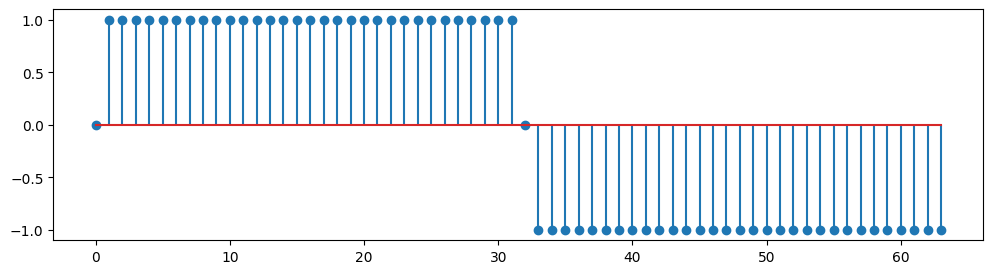

In [8]:
N = 64
plt.stem(sqw(N));

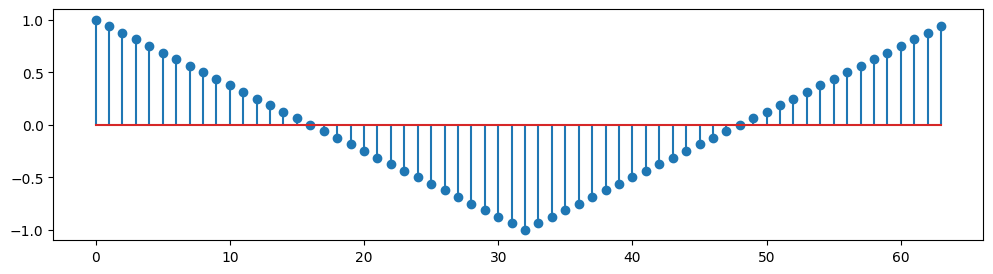

In [9]:
plt.stem(tri(N));

In [10]:
def ramp(N:int, n: np.ndarray=None) -> np.ndarray:
    n = np.arange(N) if n is None else n
    return 2 * np.mod(n, N) / (N-1) - 1

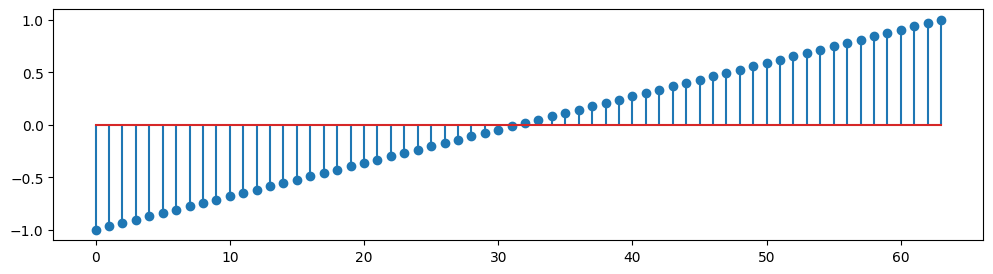

In [11]:
plt.stem(ramp(N));

# The DFT

Let $W_N = \{\mathbf{w}_k\}_{0 \le k < N}$ be the family of complex-valued harmonic oscillations of length $N$ defined as
$$
    w_k[n] = e^{j\omega_k n}, \quad \omega_k = \frac{2\pi}{N}k.
$$
Any length-$N$ signal $\mathbf{x}$ can be expressed as the linear combination
$$
    \mathbf{x} = \frac{1}{N} \sum_{k=0}^{N-1} X[k] \mathbf{w}_k;
$$
the vector of $N$ complex-valued coefficients $\mathbf{X}$ is called the Discrete Fourier Transform of $\mathbf{x}$ and it can be computed as
$$
  \mathbf{X} = \sum^{N-1}_{n=0} x[n] \mathbf{w}^*_n.
$$

The proof of this result is based on the orthogonality of the elements in $W_N$ and can be found in any textbook.

## Algorithmic implementation

Using the definitions for the elements $\mathbf{w}_k$, the DFT formulas can be rewritten in algorithmic form as such:
 * the _analysis_ formula, providing the DFT coefficients from the samples is
$$
  X[k] = \sum^{N-1}_{n=0} x[n] e^{-j \frac{2\pi}{N}nk}
$$
 * the _synthesis_ formula, providing the signal samples from the DFT coefficients is
$$
    x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] e^{j \frac{2\pi}{N} nk}.
$$

The DFT can be implemented very efficiently via the FFT algorithm, whose computational complexity is on the order of $N\log_2 N$ operations. Although NumPy includes a built-in FFT routine, it is useful (at least once in a lifetime) to write a straightforward implementation of the DFT so here are a couple of exercises:

### Exercise: DFT implementation

Complete the following DFT implementation

In [12]:
def dft_change_of_basis_matrix(N: int) -> np.ndarray:
  W = np.zeros((N, N), dtype=complex)
  for k in range(N):
    for n in range(N):
      W[k, n] = np.exp(-1j * 2 * np.pi * n * k/N)
  return W


In [13]:
def my_dft(x: np.ndarray) -> np.ndarray:
    N = len(x)
    X = np.zeros(N, dtype=complex)
    W = dft_change_of_basis_matrix(N)
    X = W @ x
    return X

Let's verify if your implementation works:

In [14]:
N = 100
x = np.random.randn(N) + 1j * np.random.randn(N)
np.allclose(my_dft(x), np.fft.fft(x))

True

### Exercise: IDFT implementation

Complete the implementation for the inverse DFT

In [15]:
def my_idft(X: np.ndarray) -> np.ndarray:
    W = dft_change_of_basis_matrix(len(X))
    x = 1/N * np.conjugate(W).T @ X
    return x

Let's verify if your implementation works:

In [16]:
np.allclose(my_idft(my_dft(x)), x)

True

### Exercise: Fourier coefficients for the square and triangular test signals

In the first part of this two-part notebook we gave the formulas for the DFT coefficients of the square and triangular waves:
\begin{align}
    Q[k] &= \begin{cases} 0 & k \text{~even} \\ \displaystyle \frac{-2j}{\tan(\pi k /N)}  & k \text{~odd} \end{cases} \\ \\
    T[k] &= \begin{cases} 0 & k \text{~even} \\ \displaystyle \frac{4}{N}\,\left(1 + \frac{1}{\tan^2(\pi k/N)}\right) & k \text{~odd} \end{cases}
\end{align}

Using the DFT algorithm, check that the numerical computation agrees with the theory.

In [19]:
# your code here
Q_theory = np.array([-2j/np.tan(np.pi*k/N) if k%2 == 1 else 0 for k in range(N)], dtype=complex)
Q_DFT = my_dft(sqw(N))
print('square wave:', np.allclose(Q_theory, Q_DFT))

T_theory = np.array([4/N * (1 + 1/np.tan(np.pi*k/N)**2) if k%2 == 1 else 0 for k in range(N)], dtype=complex)
T_DFT =  my_dft(tri(N))
print('triangular wave:', np.allclose(T_theory, T_DFT))

square wave: True
triangular wave: True


## Magnitude and phase

Up to a normalization factor $1/N$, each complex-valued DFT coefficient $X[k]$ is the weight associated to the harmonic oscillation $\mathbf{w}_k$ in the IDFT reconstruction formula. As such, it carries two pieces of information:

 * the magnitude $|X[k]|$ indicates "how much" of the signal $\mathbf{x}$ is due to an oscillatory component at frequency $\omega_k = (2\pi/N)k$
 * the phase $\angle X[k]$ indicates the phase shift that best aligns $\mathbf{x}$ with $\mathbf{w}_k$

### Example: phase-shifted sinusoid

Consider the signal $x[n] = \cos((2\pi/N)k n + \theta)$, an $N$-periodic cosine with an initial phase shift. Let's look at the magnitude and phase of its DFT

In [20]:
N, k, theta = 32, 2, 0.7
x = np.cos(2 * np.pi / N * k * np.arange(N) + theta)

X = np.fft.fft(x)
X_mag = np.round(np.abs(X), 2)
X_phase = np.round(np.angle(X), 2)

print(X_mag)

[ 0.  0. 16.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 16.  0.]


The only two nonzero coefficients are $X[k]$ and $X[N-k]$, consistent with the fact that the cosine has a frequency equal to $\omega_k = (2\pi/N)k$; the phase of these two coefficients is

In [21]:
print(X_phase[np.argwhere(X_mag)])

[[ 0.7]
 [-0.7]]


and so we have $X[k] = (N/2)\,e^{j\theta}$ and $X[N-k] = (N/2)\,e^{-j\theta} = (X[1])^*$. Using the IDFT formula:
\begin{align}
    x[n] &= (1/N)(X[k]w_k[n] + X[N-k]w_{N-k}[n]) \\ \\
     &= (1/N)(X[k]\,w_k[n] + (X[1]\,w_k[n])^*) \\ \\
     &= (2 / N)\, \Re\{X[k]\,w_k[n]\} \\ \\
     &= (2 / N)\, \Re\{(N / 2)\,e^{j((2\pi/N)kn + \theta)}\} \\ \\
     &= \cos((2\pi/N)k n + \theta)
\end{align}

# Plotting the DFT

The DFT coefficients are the _frequency-domain_ representation of the information contained in a signal; they form the so-called _spectrum_ of a signal and in this section we consider how to display this spectral information graphically.

The most common spectral visualization is a plot of the DFT coefficients in magnitude (or squared magnitude); this shows how the signal's energy is distributed across the sinusoidal components that make up the signal. The simplest thing that we can do is just plot the magnitude of the DFT data vector as-is:

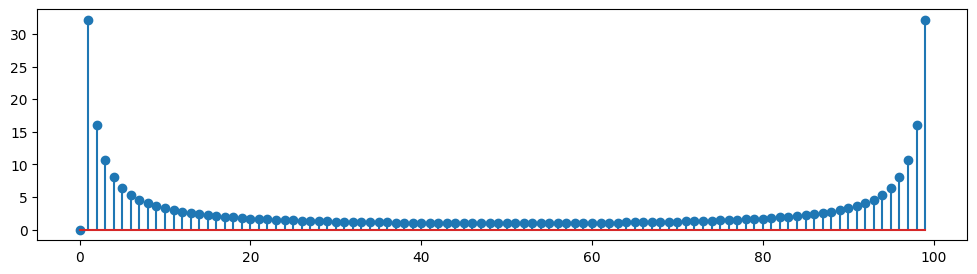

In [22]:
N = 100
plt.stem(np.abs(np.fft.fft(ramp(N))));

To make more sense of this plot, we need however to understand the structure of the the horizontal axis.

## Positive and negative frequencies

The magnitude of the $k$-th DFT coefficient indicates "how much" of the input signal is due to the sinusoidal building block $\mathbf{w}_k$, whose angular frequency is $\omega_k = (2\pi/N)k$. As we have seen in the first part of the notebook, however, when the frequency becomes larger than $\pi$, that is, when $k > N/2$, we prefer to think of  $\mathbf{w}_k$ as an oscillation with _negative_ frequency $\omega_k = (2\pi/N)k - 2\pi$. Mathematically, this is called "wrapping" the frequency over the $[-\pi, \pi]$ interval:

In [23]:
def wrap(a):
    return np.mod(a + np.pi, 2 * np.pi) - np.pi

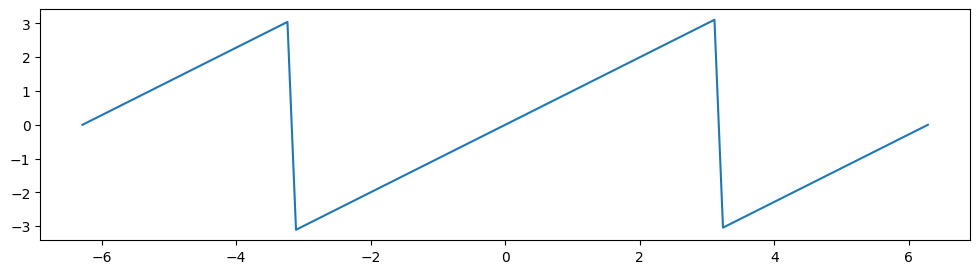

In [24]:
a = np.pi * np.linspace(-2, 2, 100)
plt.plot(a, wrap(a));

The following table resumes the values and the properties of the frequencies associated to each DFT coefficient $X[k]$


| DFT index     | frequency (wrapped)           | rotation           | notes                               |
| :--------:    | :-------:                     | -------            |-------                              |
| $k=0$         | $0$                           |  none              |                                     |
| $0 < k < N/2$ | $0 < (2\pi/N)k < \pi$         |  CCW, slow to fast |                                     |
| $k = N/2$     | $\pm\pi$                      |  fastest           | **this exists only if $N$ is even** |
| $N/2 < k < N$ | $-\pi < (2\pi/N)(k - N)  < 0$ |  CW, fast to slow  |                                     |

### Example: identifying positive and negative frequencies

The following function plots the magnitude of the DFT coefficients of a signal using different colors:
 * green for positive frequencies
 * red for negative frequencies
 * blue for the frequencies that can be considered positive or negative; one of them is the zero frequency (no rotation) and, when $N$ is even, we have also the fastest frequency $\pi$ (a point rotating at $+\pi$ (counterclockwise) produces the same sequence of positions as a point rotating at $-\pi$ (clockwise).

In [25]:
def plot_dft_split(arg):
    if isinstance(arg, int):
        X, N = np.abs(np.fft.fft(ramp(arg))), arg
    else:
        X, N = arg, len(arg)
    plt.plot([0, N-1], [0, 0], 'k')
    for k in range(N):
        if k == 0 or k == N / 2:
            color = 'C0'
        elif k < N / 2:
            color = 'C2'
        else:
            color = 'C3'
        plt.stem([k], [X[k]], color)

In [26]:
wg.interactive(plot_dft_split, arg=wg.IntSlider(min=3, max=128, value=64, description=r'N'))

interactive(children=(IntSlider(value=64, description='N', max=128, min=3), Output()), _dom_classes=('widget-i…

## Zero-centered DFT

For the puropose of visualization, it makes more sense to rearrange the DFT coefficients so that they are ordered by increasing frequency value, that is:
 * first we have the cooefficients associated to negative frequencies, from $-\pi$ up to zero
 * then the coefficient with index zero
 * then the coefficients associated to positive frequencies, up to $\pi$.

Since we want the rearragned set of DFT values to have an equal number of points to the left and to the right of the origin, we need to remember that, for $N$ even, the coefficient associated to the maximum frequency $\pi$ is both positive and negative, and therefore it must be used twice.

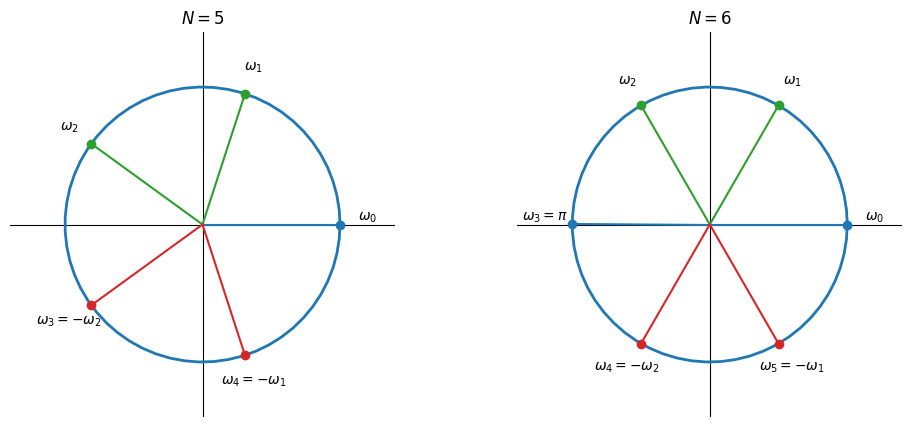

In [27]:
N = 5
plt.subplot(1,2,1)
show_freqs(N)
plt.subplot(1,2,2)
show_freqs(N+1)

### Exercise: rearranged frequency indexes

Complete the function below so that it returns a vector of integers that point to the DFT coefficients rearranged around zero; for example:
 * for $N=5$, the function should return the array `[3, 4, 0, 1, 2]`
 * for $N=6$, it should return `[3, 4, 5, 0, 1, 2, 3]` (because $N$ is even)

With such a function, we can easily plot the rearraged DFT via Numpy's index slicing:

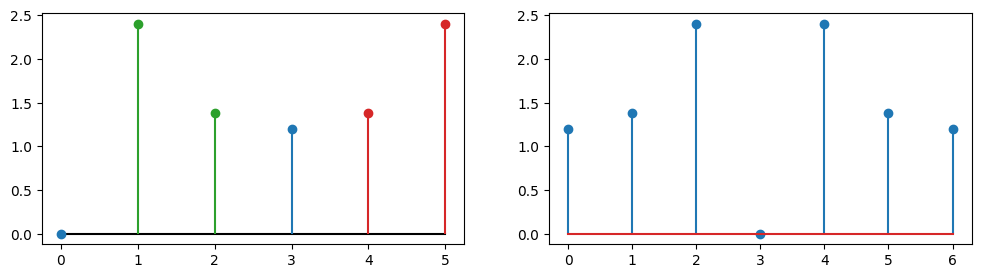

In [29]:
X = np.abs(np.fft.fft(ramp(6)))
plt.subplot(1,2,1)
plot_dft_split(X);
plt.subplot(1,2,2)
ix = np.array([3, 4, 5, 0, 1, 2, 3])
plt.stem(X[ix]);

In [35]:
def dft_idx(N):
  if N%2 == 0:
    N += 1
  ix = np.zeros(N)
  ix[:N//2] = np.arange(N//2, N - 1)
  ix[N//2:] = np.arange(N//2 + 1)
  return ix.astype(int)

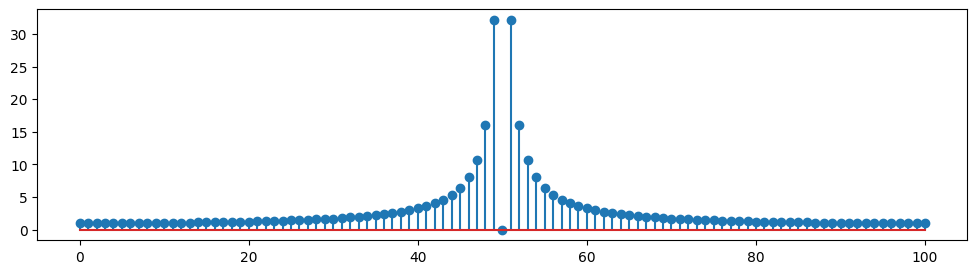

In [36]:
N=100
X = np.abs(np.fft.fft(ramp(N)))
ix = dft_idx(N)
plt.stem(X[ix]);

## Labeling the frequency axis

The final thing we need to do is properly labeling the frequency axis and this is achieved by mapping each DFT index $k$ to the frequency value of the associated oscillation $\mathbf{w}_k$. For this there are three options:
 * we can use a value in radians wrapped over the $[-\pi, \pi]$ interval: $\omega_k = \text{wrap}((2\pi/N)k)$
 * we can use the _normalized_ frequency values $\omega_k/\pi$, so that the range is $[-1, 1]$
 * if the signal is a sampled real-world signal and if we know its sampling frequency $F_s$, we can use values in hertz by multiplying the normalized frequencies by $F_s/2$; the frequency range will therefore span the $[-F_s/2, F_s/2]$ interval.

The following function returns the magnitude DFT and a vector of frequency values ready for plotting
 * by default, it returns a frequency axis in radians
 * for normalized frequencies, use `f = 1`
 * for frequencies in herts, use `f = Fs / 2`

In [37]:
def zcdftmag(x, f=np.pi):
    N = len(x)
    ix = dft_idx(N)                # [N/2, N/2 + 1, ... N-1, 0, 1, ... , N/2]
    X = np.abs(np.fft.fft(x)[ix])  # N points for N evem, N+1 for n odd
    ix[:N//2] -= N                 # [-N/2, -N/2+1, ..., -1, 0, 1, ..., N/2]
    return 2 * f * ix / N, X

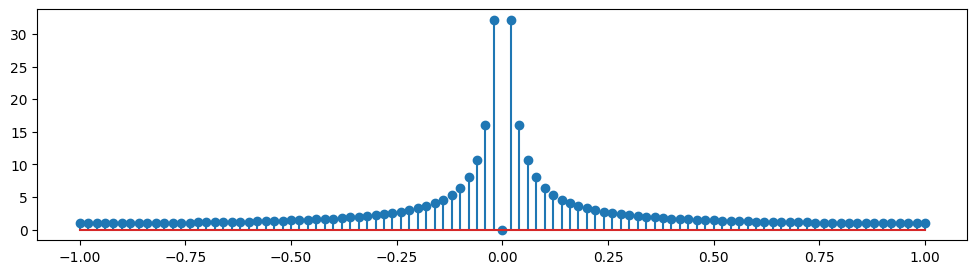

In [38]:
N=100
plt.stem(*zcdftmag(ramp(N), 1)); # normalized frequencies

### Bonus function: pretty-printing the frequency labels

This function will reformat the frequency axis and label it with multiples of $\pi/M$ for $M$ an integer of your choice:

In [39]:
def pi_frac(M):
    from fractions import Fraction
    t, w = [], []
    for d in range(-M, M+1):
        t += [np.pi * d / M]
        if d == 0:
            w += [r'$0$']
        else:
            f = Fraction(d, M)
            num = f.numerator
            a = '-' if num == -1 else '' if num == 1 else str(num)
            b = '' if f.denominator == 1 else f'/{f.denominator}'
            w += [f'${a}\\pi{b}$']
    plt.xticks(t, labels=w);

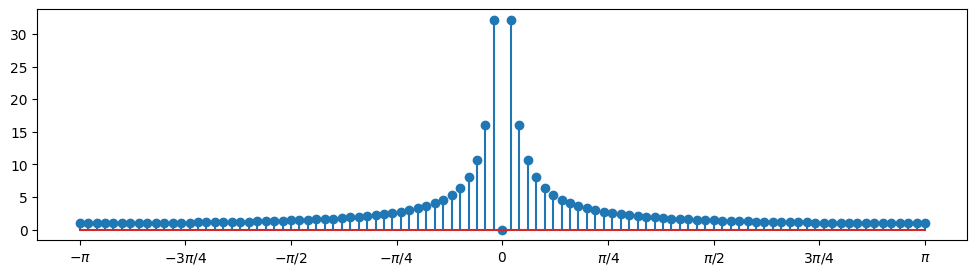

In [40]:
N=100
plt.stem(*zcdftmag(ramp(N)))
pi_frac(4)

## Symmetric magnitude spectra

By now you must have noticed that all the previous plots are symmetric, either around $N/2$ or, when the DFT coefficients are rearranged, around zero. This is because in all the examples we have computed the DFT of the real-valued ramp signal and, in fact, **the magnitude spectrum of a real-valued signal is always symmetric**.

One important consequence is that, when dealing with real-valued signals, it is customary to plot the magnitude spectrum only over the positive frequencies.

Note however that, for complex-valued signals, the magnitude spectrum is _not_ symmetric:

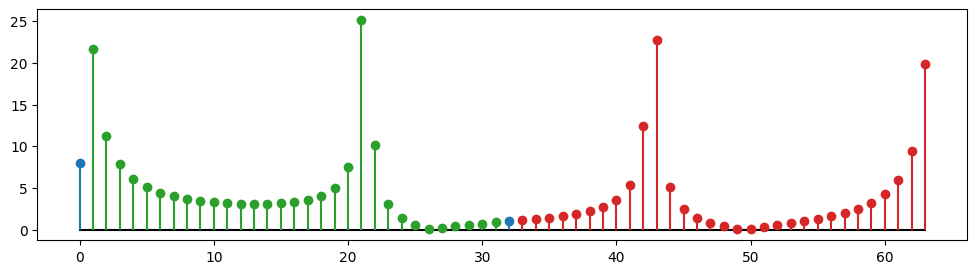

In [41]:
N = 64
plot_dft_split(np.abs(np.fft.fft(ramp(N) + 1j * tri(3, np.arange(N)))))

### Exercise: plot only the positive frequencies

Modify the `zcdftmag` function so that, if required, it only returns the labes and values for the positive frequencies

In [42]:
def zcdftmag(x, f=np.pi, pos_only=False):
    N = len(x)
    ix = dft_idx(N)[N//2:]
    X = np.abs(np.fft.fft(x)[ix])
    ix[:N//2] -= N//4
    return 2 * f * ix / N, X

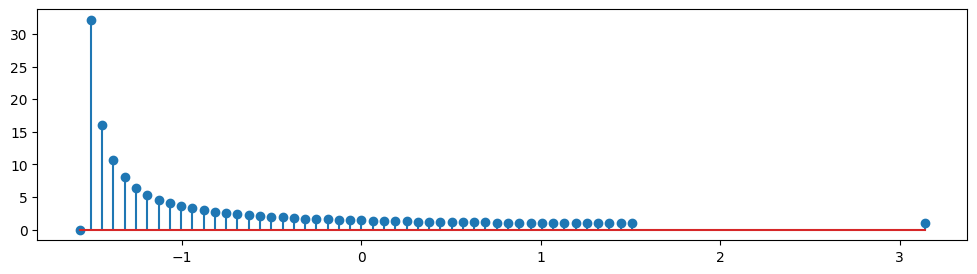

In [43]:
N=100
plt.stem(*zcdftmag(ramp(N), pos_only=True));

# The DFT as an analysis tool



## Frequency resolution

In a DFT of size $N$, the frequency separation between two consecutive coefficients is $\Delta_N = 2\pi/N$; this value is called the _frequency resolution_ of the DFT and it is only dependent on $N$, that is, on the number of data samples.

In reality, each DFT coefficient is associated not just to its nominal frequency $\omega_k = (2\pi/N)k$ but to a _frequency bin_ of width $\Delta_N$, centered in $\omega_k$. If a signal contains two or more sinusoidal components whose frequencies fall into the same frequency bin, they will not be _resolved_ by the DFT, in the sense that they will not be visible as separate spectral lines. Similarly, if a signal contains two sinusoids whose frequencies belong to neighboring bins, a plot of the DFT will not show clearly distinct spectral lines.

### Example: resolving sinusoids

Consider a length-$N$ signal defined by
$$
    x[n] = \cos(\omega_0 \, n) + \cos((\omega_0 + \delta) n), \quad n = 0, 1, \ldots, N-1
$$

Since the signal contains two sinusoids, we expect its DFT to show two clear lines corresponding to the frequencies; but the two spectral peaks  will appear distinctly only if $\delta > 2\Delta_N$ (where "distinctly" indicates peaks separated by a clear gap).

The following demo will allow you to get a feel for the resolution issues:
 * change the value of $\delta$ and verify that the spectral lines start to be separated when $|\delta/\Delta| > 2$
 * for a fixed value of $\delta$, change the length of the time-domain signal and see how it affects the resoltion
 * verify that the resolving power of the DFT does not depend on the frequency value $\omega_0$

In [44]:
def test_dft_res(N, w, d):
    n = np.arange(0, N)
    X = np.abs(np.fft.fft(np.cos(w * np.pi * n) + np.cos((w + d) * np.pi * n)))[:N//2]
    plt.stem(X)
    plt.title(f'$\\delta/\\Delta = {N * d / 2:.2f}$')

In [47]:
wg.interactive(test_dft_res, N=wg.IntSlider(64, 32, 512),
               w=wg.FloatSlider(value=0.25, min=0, max=1, step=0.01, description='$\\omega_0/\\pi$'),
               d=wg.FloatSlider(value=0, min=-0.5, max=0.5, step=0.01, description='$\\delta/\\pi$'))

interactive(children=(IntSlider(value=64, description='N', max=512, min=32), FloatSlider(value=0.25, descripti…

### Exercise: answer the following questions

 1. Start from the initial values ($\omega_0/\pi = 0.25, \delta/\pi=0$) and change the value of $\omega_0/\pi$; when do you see a single nonzero DFT coefficient? What happens in the other cases?
 2. Set $\omega_0/\pi=0.4$ and $\delta/\pi=0$; for what values of $N$ do you see a single spectral line?
 3. Set $\omega_0/\pi=0.03$; for what value of $N$ can you see two clear spectral lines?

## Real-world frequencies

For a signal whose sampling rate is known, we have seen earlier how to plot the DFT coefficients against real-world frequency values in hertz. As a reminder, the reasoning is as follows:

 * the $k$-th DFT coefficient is associated to a discrete-time oscillation with $k$ full periods over $N$ samples
 * at a sampling rate $F_s$, $N$ samples span $N/F_s$ seconds
 * the period of the oscillation is therefore $(N/F_s)/k$ and the frequency is $f_k = (k/N)F_s$

The mapping from DFT index to frequency is therefore linear; this applies to the frequency resolution of the DFT as well which, in hertz, is equal to $\Delta_f = F_s/N$ for a signal of length $N$.

### Example: the magnitude spectrum of a piano note

In the case of audio files, the sampling frequency is usually provided in the file metadata and Python provides convenient libraries to read both the metadata and the audio samples. Here for instance we load and play the recording of a single piano note:

In [48]:
import IPython
from scipy.io import wavfile

Fs, piano = wavfile.read("data/piano.wav")
print(f'the audio sampling rate is {Fs} Hz')
IPython.display.Audio(piano, rate=Fs)

FileNotFoundError: [Errno 2] No such file or directory: 'data/piano.wav'

Let's use the previous function to plot the spectrum of the note:

In [49]:
# we don't need to compute the DFT of the whole signal, given its size
plt.plot(*zcdftmag(piano[:32768], Fs /2, pos_only=True));

NameError: name 'piano' is not defined

The plot shows what a spectrum analyzer would display. The clear spectral lines indicate a periodically repeating pattern in the time-domain waveform, which is the typical characteristic of musical sounds. We can easily verify this  by plotting a portion of the time-domain data:

In [ ]:
plt.plot(piano[9000:10000]);

## Musical pitch

Sounds that contain a periodically repeating pattern evoke in a listener the sensation of musical _pitch_; waveforms with a pattern that repeats quickly are associated to notes in the so-called high register, whereas slowly repeating patterns produce notes in the low register.

### The fundamental frequency

In the frequency domain, waveforms with a pattern that repeats $f_0$ times per second will have a spectrum containing clearly distinct lines at all integer multiples of $f_0$, which is called the _fundamental frequency_ of the musical note. From the previous plot, for intance, we can see that the piano note has a clear set of spectral line whose first peak is in the vicinity of 200Hz.

To determine the exact value of the fundamental frequency (to within the resolution afforded by the DFT's length) let's search for the precise location of the peak.

### Exercise: find a local spectral peak

Complete the following function so that it returns the frequency corresponding to the maximum value of the spectrum in the $[f_\min, f_\max]$ range:

In [ ]:
def search_peak(x, Fs, fmin, fmax):
    pass

Let's test it:

In [ ]:
print('good job!' if np.abs(search_peak(piano, Fs, 200, 260) - 220.7) < 1 else 'sorry try again')

### From frequency to pitch

In Western music, the pitch of a note is indicated using the name of the note in the 12-tone equal-tempered scale, followed by a number denoting the octave that the note belongs to; for more details, see for instance [here](https://en.wikipedia.org/wiki/Equal_temperament). A full list of nominal pitch frequencies is availble [here](https://pages.mtu.edu/~suits/notefreqs.html).

The following function converts a frequency value in hertz to pitch notation:

In [ ]:
def freq2pitch(f):
    C4, delta, octave = 261.63, 2 ** (1/24), 4
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    while f < C4 / delta:
        f = f * 2
        octave -= 1
    while f > C4 * 2 * delta:
        f = f / 2
        octave += 1
    return notes[int(np.round(12 * np.log(f / C4) / np.log(2)))] + str(octave)

The piano note is in fact an A in the 3rd octave:

In [ ]:
freq2pitch(search_peak(piano, Fs, 150, 250))

### Exercise: find the pitch

Find the pitch of the note contained in the following audio file (it should be a C4):

In [ ]:
Fs_guitar, guitar = wavfile.read("data/guitar.wav")
IPython.display.Audio(guitar, rate=Fs_guitar)